# Práctica 2 - Self-Organising Maps - COUNTRIES
## Preparación de entorno
#### Importar librerías de código

In [1]:
# from __future__ import division
import os
import json
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pandas as pd
from mpl_toolkits.basemap import Basemap
import tensorflow as tf 
from tensorflow import keras
from keras.models import load_model
import geopandas as gpd


%matplotlib inline

#### Dataset que se va a utilizar para el entrenamiento

In [2]:
# Código para obtener el Dataset que se va a usar en el entrenamiento
datos = pd.read_csv("Countries2010.csv")

## SOM Setup
#### Variables definidas por el alumno

In [3]:
# Inicializa tamaño del mapa de Kohonen, número de iteraciones y learning rate
# Inicializa normalizar_datos dependiendo de si tienes que normalizar los datos o no
lado_mapa = int(input("Introduzca el lado"))
periodo = int(input("Introduzca el Periodo"))
learning_rate = float(input("Introduzca el Learning Rate"))

#### A partir de este punto solo hay cálculos. No se introducen más valores "a mano"

In [4]:
# Establece el numero de entradas del mapa y el número de datos que se van a usar para entrenar. 
# Utiliza una función que obtenga automáticamente los valores a partir del Dataset.
num_entradas = 17
num_datos = 10000

# Calcula el vecindario inicial. Debe ser la mitad del lado del mapa de Kohonen
vecindario = lado_mapa / 2

# Normaliza los datos si fuese necesario dividiendo cada dato por el máximo en la matriz
normalized_data = datos.copy()
cont = 0
for column in normalized_data.columns:
    if cont != 0:
        min_val = normalized_data[column].min()
        max_val = normalized_data[column].max()
        normalized_data[column] = (normalized_data[column] - min_val) / (max_val - min_val)
    cont+=1
    
matriz_pesos = np.random.random(size = (lado_mapa, lado_mapa, num_entradas))

#### Funciones para entrenar/clasificar

In [5]:
# Función para encontrar la BMU
"""
   Encuentra la BMU para un patrón de entrada.
   Entradas: (patrón_de_entrada, matriz_de_pesos, número_de_entradas)
   Salidas:  (bmu, bmu_idx) tupla donde
               bmu: vector de pesos de la neurona ganadora
               bum_idx: coordenadas de la neurona ganadora
"""
def calcular_bmu(patron_entrada, m_pesos, m):
   distancias = np.linalg.norm(m_pesos.astype(float) - patron_entrada.astype(float), axis=2)
   bmu_idx = np.unravel_index(np.argmin(distancias), distancias.shape)
   bmu = m_pesos[bmu_idx]
   return bmu, bmu_idx

In [6]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta)
"""
   Calcula el Learning Rate (eta) que corresponde a la i-ésima presentación.
   Entradas: (learning_rate_inicial, iteracion, período)
   Salidas:  learning_rate para la iteración i

"""
def variacion_learning_rate(lr_inicial, i, n_iteraciones):
   eta = lr_inicial * (1 - ( i / n_iteraciones))
   return eta

In [7]:
# Función para calcular el descenso del vecindario (v)
"""
   Calcula el vecindario  (v) que corresponde a la i-ésima presentación.
   Entradas: (vecindario_inicial, iteracion, período)
   Salidas:  lvecindario para la iteración i

"""
def variacion_vecindario(vecindario_inicial, i, n_iteraciones):
   variacion = 1 + vecindario_inicial * (1 - (i / n_iteraciones))
   return variacion

In [8]:
# Función para calcular el descenso del coeficiente de aprendizaje (eta) en función de la distancia a la BMU
"""
   Calcula la amortiguación de eta en función de la distancia en el mapa entre una neurona y la BMU.
   Entradas: (distancia_BMU, vecindario_actual)
   Salidas:  amortiguación para la iteración

"""
def decay(distancia_BMU, vecindario_actual):
    return np.exp(-distancia_BMU**2 / (2*vecindario_actual**2))
    

In [9]:
def calcular_mse(datos, matriz_pesos, patron):
    """
    Esta función calcula el error cuadrático medio entre los datos y los pesos de la red SOM.
    :param datos: matriz de datos de entrada
    :param matriz_pesos: matriz de pesos de la red SOM
    :return: valor del error cuadrático medio
    """
    # Calcula la BMU
    mse = 0
    bmu_aux, bmu_idx_aux = calcular_bmu(patron, matriz_pesos, num_entradas)
    # Calcula la distancia entre el patrón y la BMU
    distancia = np.sqrt(np.sum((patron - matriz_pesos) ** 2))
    mse += distancia ** 2
    return mse / datos.shape[1]

### Funcion para pintar la variación del Learning rate

In [10]:
def plot_learning_rate(lrate):
    """
    Esta función grafica la variación del learning rate en cada iteración.
    :param lrate: una lista de valores de learning rate en cada iteración
    """
    # Crear la figura
    fig, ax = plt.subplots()

    # Crear el gráfico de línea
    ax.plot(lrate, label='Learning rate')

    # Añadir etiquetas y título
    ax.set_xlabel('Iteración')
    ax.set_ylabel('Valor del learning rate')
    ax.set_title('Variación del learning rate')

    # Mostrar la leyenda y el gráfico
    ax.legend()
    plt.show()

### Funcion para pintar la variación de la Curva de Aprendizaje

In [11]:
def plot_curva_aprendizaje(mse):
    """
    Función que grafica la curva de aprendizaje de un SOM.

    Args:
    mse: ndarray, array que contiene el error cuadrático medio por época.
    """
    plt.plot(range(len(mse)), mse)
    plt.title('Curva de aprendizaje')
    plt.xlabel('Época')
    plt.ylabel('Error cuadrático medio')
    plt.show()

## SOM Entrenamiento

In [12]:
# Entrena la red con el dataset de entrenamiento
mse = []
etahistoricos = np.zeros(periodo)
for i in range(periodo):
    for patron in normalized_data.T:
        # Calcula la BMU
        aux = normalized_data.T[patron].iloc[1:].values

        bmu, bmu_idx = calcular_bmu(aux, matriz_pesos, num_entradas)
        # Calcula el descenso del coeficiente de aprendizaje y del vecindario
        eta = variacion_learning_rate(learning_rate, i, periodo)
        etahistoricos[i] = eta 
        v = variacion_vecindario(vecindario, i, periodo)
        # Actualiza los pesos de las neuronas
        for x in range(matriz_pesos.shape[0]):
            for y in range(matriz_pesos.shape[1]):
                w = matriz_pesos[x, y, :]
                
                distancia = np.sqrt(np.sum((np.array([x, y]) - np.array(bmu_idx)) ** 2))
                if distancia <= v:
                    # Calcula la amortiguación de eta
                    amortiguacion = decay(distancia, v)
                    # Actualiza los pesos
                    matriz_pesos[x, y, :] = w + (eta * amortiguacion * (aux - w))
    mse.append(calcular_mse(normalized_data, matriz_pesos, aux))
                    
    if i % 100 == 0:
        print('Iteración %d/%d' % (i, periodo))
print("Entrnamiento finalizado")


Iteración 0/5000
Iteración 100/5000
Iteración 200/5000
Iteración 300/5000
Iteración 400/5000
Iteración 500/5000
Iteración 600/5000
Iteración 700/5000
Iteración 800/5000
Iteración 900/5000
Iteración 1000/5000
Iteración 1100/5000
Iteración 1200/5000
Iteración 1300/5000
Iteración 1400/5000
Iteración 1500/5000
Iteración 1600/5000
Iteración 1700/5000
Iteración 1800/5000
Iteración 1900/5000
Iteración 2000/5000
Iteración 2100/5000
Iteración 2200/5000
Iteración 2300/5000
Iteración 2400/5000
Iteración 2500/5000
Iteración 2600/5000
Iteración 2700/5000
Iteración 2800/5000
Iteración 2900/5000
Iteración 3000/5000
Iteración 3100/5000
Iteración 3200/5000
Iteración 3300/5000
Iteración 3400/5000
Iteración 3500/5000
Iteración 3600/5000
Iteración 3700/5000
Iteración 3800/5000
Iteración 3900/5000
Iteración 4000/5000
Iteración 4100/5000
Iteración 4200/5000
Iteración 4300/5000
Iteración 4400/5000
Iteración 4500/5000
Iteración 4600/5000
Iteración 4700/5000
Iteración 4800/5000
Iteración 4900/5000
Entrnamiento

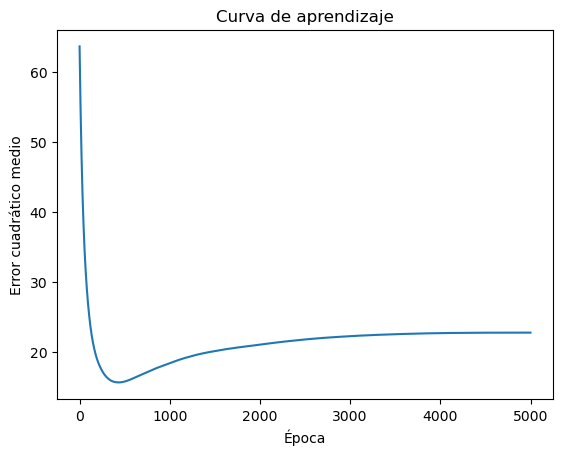

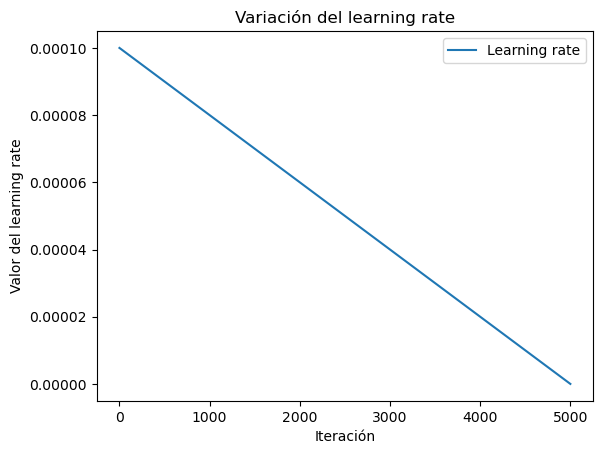

In [13]:
plot_curva_aprendizaje(mse)
plot_learning_rate(etahistoricos)

## SOM Clasificación

In [14]:
mapa_clasificacion_Modificado = {}
for i in range (lado_mapa):
    for j in range (lado_mapa):
        mapa_clasificacion_Modificado['({}, {})' .format(i,j)] = []

mapa_clasificacion_Con_vectores = {'Ethiopia' : [], 'Venezuela, RB' : [], 'Norway' : []}

        
mapa_clasificacion = np.zeros(matriz_pesos.shape)
mapa_activaciones = np.zeros((lado_mapa, lado_mapa))
mapa_distancias = np.zeros((lado_mapa, lado_mapa))
print("Mapa de clasificación con la neurona, país y vector. \n")
# Recorrer todo el dataset de entrenamiento
for patron_entrada in normalized_data.T: # Obtener el patrón de entrada
    # Calcular la BMU y sus coordenadas
    aux = normalized_data.T[patron_entrada].iloc[1:].values
    bmu, bmu_idx = calcular_bmu(aux, matriz_pesos, num_entradas)
    bmu_x, bmu_y = bmu_idx
    coord = '('+ str(bmu_x) +', ' + str(bmu_y) + ')' 
    mapa_clasificacion[bmu_x, bmu_y] = patron
    mapa_clasificacion_Modificado[coord].append(datos.CountryName[patron_entrada])
    if(datos.CountryName[patron_entrada] in mapa_clasificacion_Con_vectores):
        mapa_clasificacion_Con_vectores[datos.CountryName[patron_entrada]].append(bmu)
    # Imprimir las coordenadas de la BMU
    
    print("Nombre del País {}: BMU en ({}, {}) con vector ({})".format(datos.CountryName[patron_entrada], bmu_x, bmu_y, bmu))

    # Actualizar los mapas de clasificación, activaciones y distancias
         
    mapa_activaciones[bmu_x, bmu_y] += 1

    mapa_distancias[bmu_x, bmu_y] += np.mean(np.linalg.norm(aux - matriz_pesos[bmu_x, bmu_y])) 
# Calcular el número de clases
num_clases = len(np.unique(mapa_clasificacion))

# Calcular la distancia media y el Error Topológico del mapa
error_cuantificacion = np.mean(np.linalg.norm(matriz_pesos - mapa_clasificacion, axis=2)) / num_entradas


error_topologico = 0
for x in range(lado_mapa):
    for y in range(lado_mapa):
        vecinos = [(i, j) for i in range(x-1, x+2) for j in range(y-1, y+2) if (i >= 0 and i < lado_mapa and j >= 0 and j < lado_mapa)]
        vecinos_activos = [v for v in vecinos if mapa_activaciones[v] > 0]
        if vecinos_activos:
            vecinos_distancias = [np.linalg.norm(matriz_pesos[x, y] - matriz_pesos[i, j]) for (i, j) in vecinos_activos]
max_distancia = np.nanmax(vecinos_distancias)
min_distancia = np.nanmin(vecinos_distancias)
if min_distancia > 0:
    error_topologico += max_distancia / min_distancia



Mapa de clasificación con la neurona, país y vector. 

Nombre del País Afghanistan: BMU en (0, 16) con vector ([0.57020926 0.01186105 0.00146114 0.25118913 0.34081504 0.63891619
 0.5001369  0.63611157 0.84082336 0.10312871 0.25374047 0.23123364
 0.76870859 0.18320081 0.04400338 0.01670101 0.1481903 ])
Nombre del País Albania: BMU en (16, 12) con vector ([0.14044628 0.06701379 0.02628971 0.05145505 0.93484766 0.15084406
 0.0595068  0.10344487 0.1735407  0.47229626 0.42379522 0.48142689
 0.51857437 0.55203001 0.41168399 0.10747909 0.09424079])
Nombre del País Algeria: BMU en (8, 7) con vector ([0.27392795 0.04703732 0.01052645 0.05689201 0.84200418 0.24392636
 0.10988492 0.18095035 0.44950201 0.23501166 0.3681496  0.59710087
 0.402899   0.48625527 0.2679812  0.08549513 0.10791697])
Nombre del País Antigua and Barbuda: BMU en (19, 18) con vector ([0.16774386 0.07360957 0.02131966 0.05322638 0.9160785  0.1712571
 0.07483899 0.1190871  0.30369681 0.32985495 0.42441441 0.25400573
 0.74292559

In [15]:
print("Numero de clases ", num_clases)
print("Error de cuantificacion ", error_cuantificacion)
print("Error topologico ", error_topologico)

Numero de clases  2
Error de cuantificacion  13.13077427102003
Error topologico  0



MAPA ACTIVACIONES
[[3. 1. 0. 0. 1. 0. 1. 0. 3. 1. 1. 1. 2. 3. 2. 0. 2. 1. 0. 2.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 3.]
 [0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 3.]
 [1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 2. 0. 0. 0. 1. 2.]
 [1. 1. 0. 0. 0. 0. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1.]
 [2. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 2. 0. 0. 0. 0. 1. 0. 0. 2. 0. 0. 2. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1.]
 [2. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0

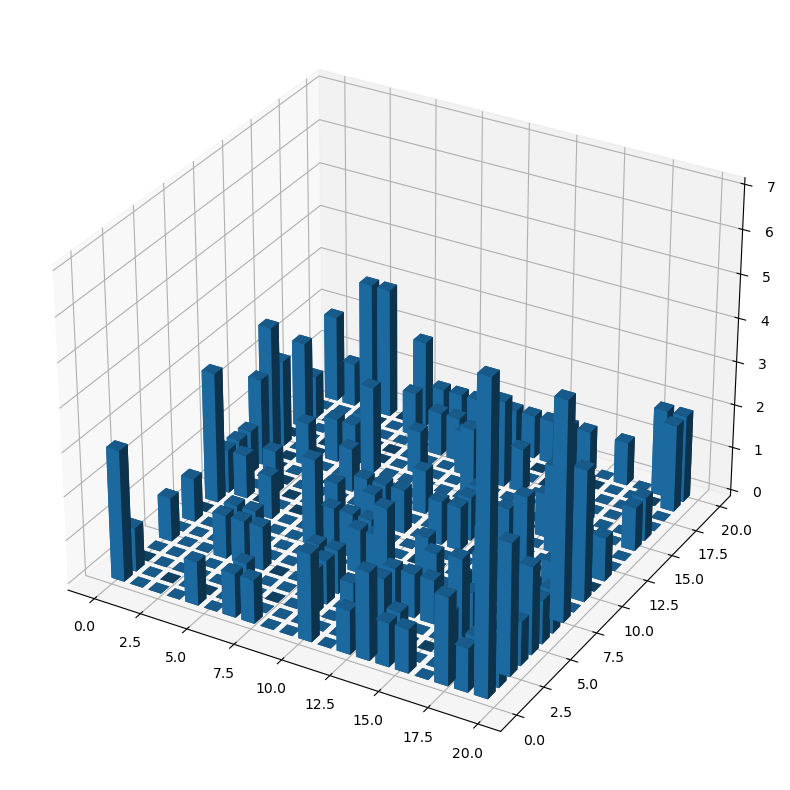

In [16]:
print("\nMAPA ACTIVACIONES")
print(mapa_activaciones)
print("\nMAPA CLASIFICACION CON PAISES POR NEURONA")
print(json.dumps(mapa_clasificacion_Modificado, indent=2))
print("\nMAPA DISTANCIAS")
print(mapa_distancias)
#HISTORIGRAMA 3D DE LA MATRIZ DE ACTVACION
print("\nHISTORIGRAMA 3D DE LA MATRIZ DE ACTVACION")
# Agregar barra de colores
fig = plt.figure(figsize = (10,10))
hist = fig.add_subplot(111, projection='3d')


xpos = [range(mapa_activaciones.shape[0])] # El largo del eje x es igual a una lista que guarda el número de neuronas en el mapa de activación
ypos = [range(mapa_activaciones.shape[0])]

xpos, ypos = np.meshgrid(xpos, ypos) # Crea una matriz a partir de las listas creadas con anterioridad

xpos = xpos.flatten('F') # Pasa la matriz creada a una lista, la f indica que se hace por columnas de la matriz
ypos = ypos.flatten('F')

zpos = np.zeros_like(xpos) # Creamos una lista del mismo tamaño que x qe rellenaremos con los valores del mapa

dx = dy = 0.7 * np.ones_like(zpos) # Indicamos el grosor de las barras

dz = mapa_activaciones.flatten() # Damos el valor a la z con el del mapa de activaciones



hist.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
plt.show()

### Cuestion 3.2

In [17]:
print("Mapa de clasificación con vectores para los países Etiopía, Venezuela y Noruega")
print(mapa_clasificacion_Con_vectores)


Mapa de clasificación con vectores para los países Etiopía, Venezuela y Noruega
{'Ethiopia': [array([0.45062046, 0.00804388, 0.00226615, 0.28244596, 0.37110957,
       0.5250734 , 0.36680682, 0.48927561, 0.8004    , 0.10558619,
       0.2814131 , 0.17266584, 0.82728329, 0.17862868, 0.05831587,
       0.0151795 , 0.11591069])], 'Venezuela, RB': [array([0.21224473, 0.10408874, 0.02176078, 0.05299868, 0.8645094 ,
       0.19114629, 0.08590728, 0.13963605, 0.41785854, 0.20567799,
       0.40463857, 0.75885483, 0.24141586, 0.54326086, 0.37192642,
       0.16300256, 0.1586962 ])], 'Norway': [array([0.04473696, 0.48572021, 0.11782253, 0.00838464, 0.99688401,
       0.02921932, 0.010131  , 0.01743345, 0.10562604, 0.65439206,
       0.49010278, 0.82407812, 0.17591317, 0.58797825, 0.86152712,
       0.38676044, 0.06098819])]}


### Cuestion 3.3

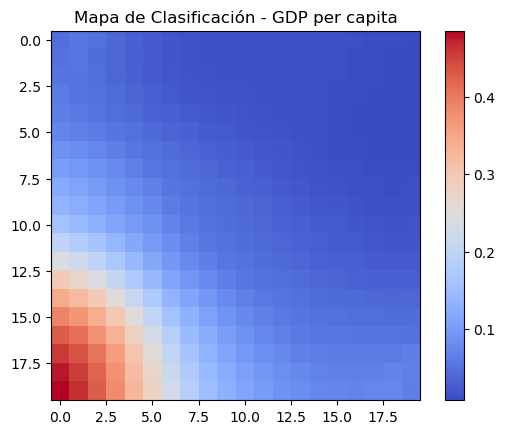

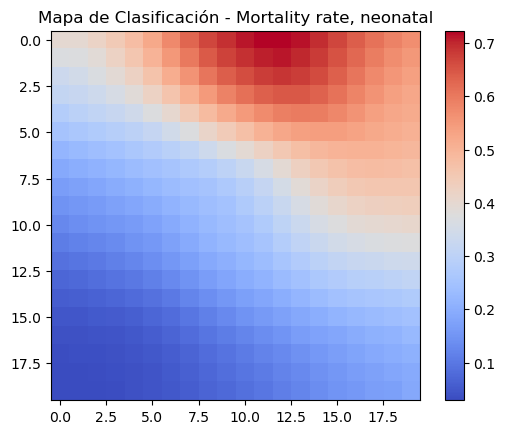

In [18]:
# Seleccionamos los pesos correspondientes a GDP per capita y Mortality rate, neonatal
gdp_weights = matriz_pesos[:,:,1]
neonatal_weights = matriz_pesos[:,:,5]

# Creamos el gráfico de dispersión para GDP per capita
plt.imshow(gdp_weights, cmap='coolwarm')
plt.colorbar()
plt.title('Mapa de Clasificación - GDP per capita')
plt.show()

# Creamos el gráfico de dispersión para Mortality rate, neonatal
plt.imshow(neonatal_weights, cmap='coolwarm')
plt.colorbar()
plt.title('Mapa de Clasificación - Mortality rate, neonatal')
plt.show()


### Mapa

In [23]:
if(os.path.exists("mapa")) == 0:
    os.mkdir("mapa")
np.save('mapa/gdp_weights.npy', gdp_weights)
np.save('mapa/pesos.npy', matriz_pesos)
np.save('mapa/nombresPaises.npy', np.array(datos.CountryName))
np.save('mapa/gdp_data.npy', np.array(datos.GDP_per_capita_current_US))

C:\Users\Guille\AppData\Local\Temp\ipykernel_6956\252878629.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  world['Neurona'][j] = clave
C:\Users\Guille\AppData\Local\Temp\ipykernel_6956\252878629.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  world['ColorR'][j] = rand1
C:\Users\Guille\AppData\Local\Temp\ipykernel_6956\252878629.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  world['ColorG'][j] = rand2
C:\Users\Guille\Ap

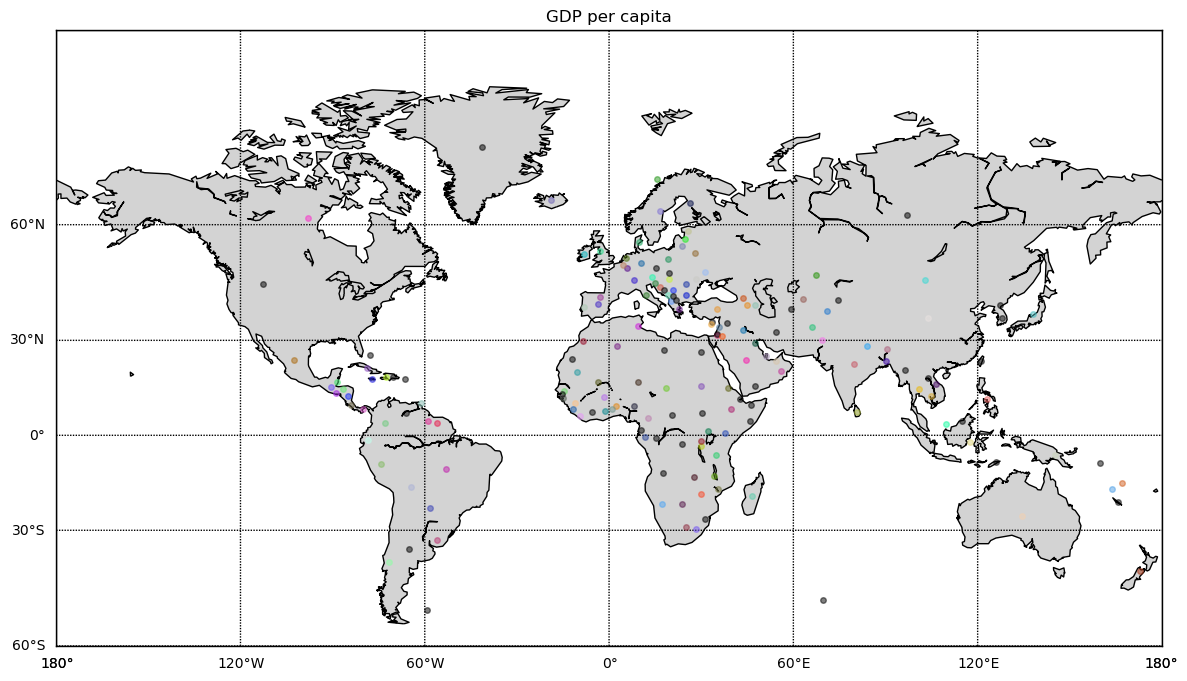

In [24]:

# cargar el modelo de red neuronal previamente entrenado
model = np.load('mapa/pesos.npy')

# cargar los datos de GDP per capita y nombres para cada país
gdp_pesos = np.load('mapa/gdp_weights.npy', allow_pickle = True)
countries = np.load('mapa/nombresPaises.npy', allow_pickle = True)
gdp_data = np.load('mapa/gdp_data.npy', allow_pickle= True)

#cargamos el datset de geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
datosMapa = {'name': [], 'Neurona': []}
#creamos las columnas que nos van a hacer falta 
world["Neurona"] = np.zeros(len(world['name']))
world["ColorR"] = np.zeros(len(world['name']))
world["ColorG"] = np.zeros(len(world['name']))
world["ColorB"] = np.zeros(len(world['name']))

#Usamos el diccionario que guarda los paises que reconoce cada neurona para generar un mismo colorRGB
#aleatorio en los paises de cierta neurona
for clave, array in mapa_clasificacion_Modificado.items():
    for i in array:
        rand1 = np.random.random(size=1)
        rand2 = np.random.random(size=1)
        rand3 = np.random.random(size=1)
        for j in range (len(world['name'])):
             if world['name'][j] == i:
                world['Neurona'][j] = clave 
                world['ColorR'][j] = rand1
                world['ColorG'][j] = rand2
                world['ColorB'][j] = rand3

# Plotear el mapa del mundo con colores según GDP per capita
fig = plt.figure(figsize=(16, 8))
m = Basemap(projection='mill', llcrnrlat=-60, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180)
m.drawcoastlines()
m.drawmapboundary()
m.fillcontinents(color='lightgray', lake_color='lightgray')
m.drawparallels(range(-90, 90, 30), labels=[1, 0, 0, 0])
m.drawmeridians(range(-180, 180, 60), labels=[0, 0, 0, 1])

#Recorre el dataset para pintar cada punto del pais con su color correspondiente
for idx, row in world.iterrows():
    x, y = m(row.geometry.centroid.x, row.geometry.centroid.y)    
    
    colorR = row['ColorR']
    colorG = row['ColorG']
    colorB = row['ColorB']
    num_color = [colorR, colorG, colorB]
    m.plot(x, y, 'o', markersize=4, color=num_color, alpha=0.5)
plt.title('GDP per capita')
plt.show()
